In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats as stats

In [2]:
import rpy2
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

from rpy2.robjects.packages import importr, data


utils = importr('utils')
base = importr('base')
%load_ext rpy2.ipython

In [3]:
def to_rdf(df):
    with (robjects.default_converter + pandas2ri.converter).context():
        rdf = robjects.conversion.get_conversion().py2rpy(df)
    return rdf

def to_df(rdf):
    with (robjects.default_converter + pandas2ri.converter).context():
        df = robjects.conversion.get_conversion().rpy2py(rdf)

    return df



In [4]:
%%R
R.version.string

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages


## Instalar pacotes do R localmente (só para seu usuário)
Talvez é necessário usar
```
utils.install_packages('mirt')
utils.install_packages('mirtCAT')

```
e o equivalente de outros pacotes.


In [5]:
mirt = importr('mirt')
mirtcat = importr("mirtCAT")

In [6]:
df = pd.read_csv('data/ch19.csv')
df

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,87709,112135,81689,97975,118108,66219,111877,acertos,caderno,nota_inep
0,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,16,508,543.6
1,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,0,0,15,508,492.6
2,0,1,1,0,1,1,0,0,0,1,...,0,1,0,0,1,0,1,23,508,587.6
3,0,1,1,0,1,1,1,0,0,1,...,0,0,0,0,1,0,1,20,508,571.6
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,14,508,492.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,0,0,1,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,19,507,522.7
31498,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,15,507,500.4
31499,1,1,1,0,1,1,0,0,1,1,...,1,1,1,0,0,0,0,20,507,560.5
31500,0,1,1,1,0,1,1,0,0,1,...,0,1,0,1,0,1,1,19,507,544.0


In [7]:
resp = df.iloc[:,range(43)]
resp

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,118054,66498,88308,87709,112135,81689,97975,118108,66219,111877
0,0,1,1,0,0,1,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1,0,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
2,0,1,1,0,1,1,0,0,0,1,...,0,1,1,0,1,0,0,1,0,1
3,0,1,1,0,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,0,0,1,0,0,0,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
31498,0,0,0,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,0
31499,1,1,1,0,1,1,0,0,1,1,...,0,0,0,1,1,1,0,0,0,0
31500,0,1,1,1,0,1,1,0,0,1,...,0,1,0,0,1,0,1,0,1,1


In [8]:
rdf = to_rdf(resp)
rdf

,,86751,83820,77940,118034,...,66219,111877
0,0,0,1,1,0,...,0,0
1,1,0,1,0,0,...,0,0
2,2,0,1,1,0,...,0,1
3,3,0,1,1,0,...,0,1
4,4,0,1,0,0,...,1,0
5,5,0,1,1,0,...,1,1
6,6,0,1,1,0,...,0,0
7,7,0,0,0,0,...,0,0
...,...,...,...,...,...,...,...,...
31500,31500,0,1,1,1,...,1,1


In [9]:
istats = mirt.itemstats(rdf)
istats = to_df(istats[1])
istats.sort_values("total.r_if_rm")

,N,mean,sd,total.r,total.r_if_rm,alpha_if_rm
96596,31502,0.235160,0.424105,0.130874,0.068536,0.817323
118024,31502,0.157228,0.364021,0.156081,0.102924,0.815946
81689,31502,0.198813,0.399113,0.161652,0.103394,0.816198
111820,31502,0.133833,0.340478,0.172879,0.123410,0.815363
66219,31502,0.392927,0.488409,0.195224,0.124378,0.816443
86934,31502,0.377309,0.484721,0.197014,0.126749,0.816335
86751,31502,0.131769,0.338245,0.180365,0.131330,0.815187
89147,31502,0.296140,0.456561,0.220970,0.155377,0.815260
84888,31502,0.254333,0.435493,0.224282,0.161845,0.814943
97975,31502,0.342835,0.474665,0.243282,0.175619,0.814799


In [18]:
%time model3pl = mirt.mirt(rdf,1,itemtype="3PL",method="EM",SE=True)


Iteration: 500, Log-Lik: -791320.831, Max-Change: 0.00057

R[write to console]: EM cycles terminated after 500 iterations.





Calculating information matrix...
CPU times: user 4min 2s, sys: 0 ns, total: 4min 2s
Wall time: 4min 1s


In [21]:
%%R -i model3pl -o coef3pl
coef3pl = coef(model3pl,simplify=FALSE,IRTpars=TRUE,printSE=TRUE)


In [22]:
coef3pl = to_df(coef3pl)
coef3pl = pd.DataFrame([np.concatenate([value[0],value[1]]) for key,value in coef3pl.items()],index=coef3pl.keys(),columns=['a','b','c','u','a_se','b_se','c_se','u_se'])
coef3pl = coef3pl.drop(index="GroupPars")
coef3pl = coef3pl.set_index(coef3pl.index.astype('int'))
coef3pl

,a,b,c,u,a_se,b_se,c_se,u_se
86751,3.349176,2.064273,0.103179,1.0,0.164493,0.026551,0.002006,NaN
83820,1.668791,0.124362,0.231826,1.0,0.059228,0.035923,0.014627,NaN
77940,0.704043,-0.354621,0.178133,1.0,0.056232,0.265673,0.070245,NaN
118034,2.190002,1.302246,0.164548,1.0,0.077340,0.017159,0.004209,NaN
84811,1.696237,0.395927,0.168915,1.0,0.054027,0.025439,0.010495,NaN
96447,2.284789,0.499533,0.131928,1.0,0.064450,0.015789,0.006611,NaN
96302,0.820596,0.055822,0.005306,1.0,0.016923,0.023234,0.006042,NaN
111820,1.476943,2.743631,0.097621,1.0,0.099315,0.082337,0.003126,NaN
118033,2.122084,0.788235,0.334085,1.0,0.089340,0.022235,0.007422,NaN
84769,1.572149,1.365492,0.143805,1.0,0.064507,0.021743,0.006206,NaN


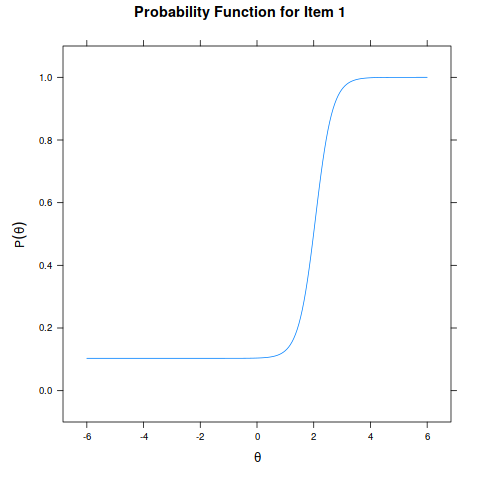

In [23]:
%%R -i model3pl
itemplot(model3pl,1)

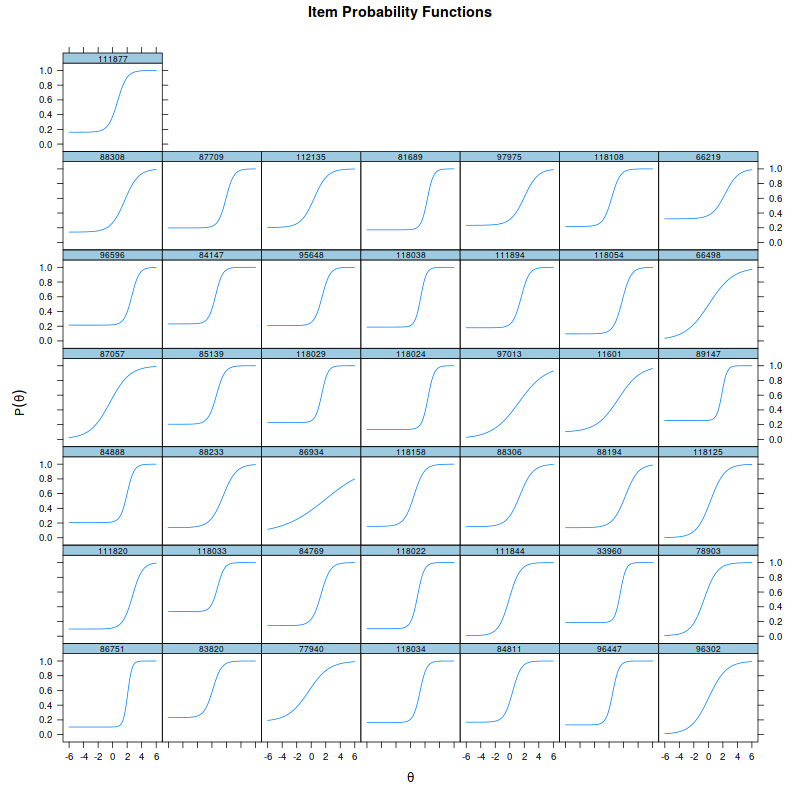

In [24]:
%%R -w 800 -h 800
plot(model3pl,type="trace", facet_items=TRUE)

In [25]:
thetas3pleap = mirt.fscores(model3pl,method="EAP",full_scores=True,full_scores_SE=True)

In [26]:
to_df(thetas3pleap)[:,1]

array([0.337179  , 0.46219645, 0.28012556, ..., 0.3824641 , 0.32709067,
       0.45711052])

In [27]:
df['theta3pleap'] = to_df(thetas3pleap)[:,0]
df['theta3pleapse'] = to_df(thetas3pleap)[:,1]


In [28]:
df[:10]

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,81689,97975,118108,66219,111877,acertos,caderno,nota_inep,theta3pleap,theta3pleapse
0,0,1,1,0,0,1,0,0,1,0,...,0,0,1,0,0,16,508,543.6,0.359610,0.337179
1,0,1,0,0,1,0,0,0,1,1,...,1,0,0,0,0,15,508,492.6,-0.249061,0.462196
2,0,1,1,0,1,1,0,0,0,1,...,0,0,1,0,1,23,508,587.6,0.939713,0.280126
3,0,1,1,0,1,1,1,0,0,1,...,0,0,1,0,1,20,508,571.6,0.715976,0.297574
4,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,14,508,492.9,-0.267143,0.479709
5,0,1,1,0,1,1,0,1,1,1,...,0,0,0,1,1,20,508,551.3,0.390940,0.386311
6,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,5,508,375.0,-1.431332,0.586911
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,9,508,416.3,-1.008775,0.503265
8,0,1,1,0,1,1,1,0,1,1,...,0,1,1,1,0,28,508,610.7,1.214045,0.259143
9,0,1,1,1,0,1,1,0,1,0,...,1,0,1,0,0,22,508,586.1,0.876971,0.299497


<AxesSubplot:xlabel='theta3pleap', ylabel='Count'>

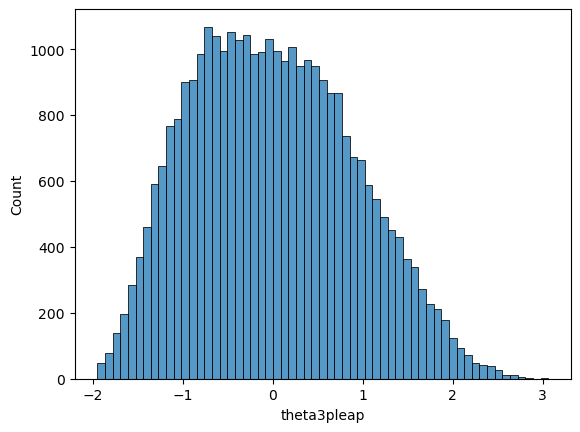

In [29]:
sns.histplot(df,x='theta3pleap')

In [30]:
df[['nota_inep','theta3pleap']].corr()

,nota_inep,theta3pleap
nota_inep,1.000000,0.993019
theta3pleap,0.993019,1.000000


<ErrorbarContainer object of 3 artists>

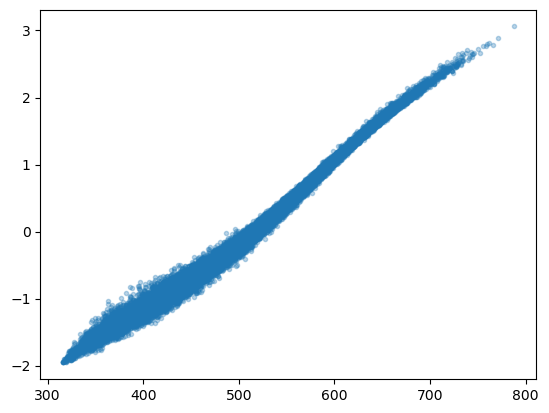

In [31]:
#plt.errorbar(df['nota_inep'],df['theta3pleap'],yerr=df['theta3pleapse'],fmt=".",alpha=0.3)
plt.errorbar(df['nota_inep'],df['theta3pleap'],fmt=".",alpha=0.3)

Text(0, 0.5, 'Nota modelo 3PL')

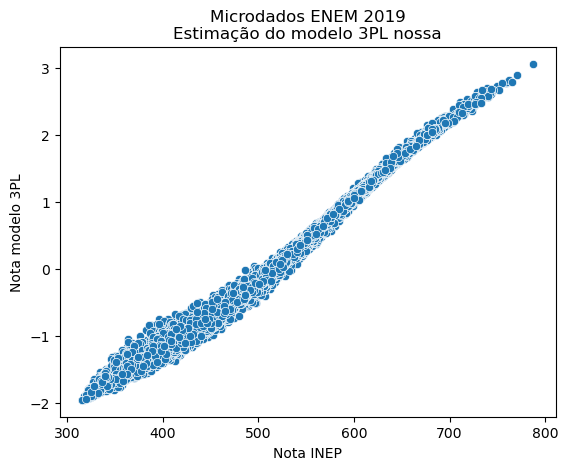

In [72]:
ax = sns.scatterplot(df,y='theta3pleap',x='nota_inep')
ax.set_title("Microdados ENEM 2019\nEstimação do modelo 3PL nossa")
ax.set_xlabel("Nota INEP")
ax.set_ylabel("Nota modelo 3PL")
#sns.scatterplot(df,x='acertos',y='theta3plmap')

In [ ]:
print(mirt.summary(model3pl))

          F1     h2
86751  0.891 0.7948
83820  0.700 0.4901
77940  0.382 0.1461
118034 0.790 0.6234
84811  0.706 0.4983
96447  0.802 0.6431
96302  0.434 0.1886
111820 0.655 0.4296
118033 0.780 0.6085
84769  0.679 0.4604
118022 0.791 0.6263
111844 0.618 0.3815
33960  0.837 0.7004
78903  0.543 0.2953
84888  0.781 0.6097
88233  0.546 0.2982
86934  0.192 0.0367
118158 0.646 0.4168
88306  0.549 0.3019
88194  0.554 0.3066
118125 0.516 0.2660
87057  0.394 0.1549
85139  0.714 0.5100
118029 0.810 0.6561
118024 0.809 0.6550
97013  0.302 0.0915
11601  0.359 0.1290
89147  0.860 0.7390
96596  0.751 0.5637
84147  0.767 0.5888
95648  0.738 0.5448
118038 0.832 0.6916
111894 0.725 0.5258
118054 0.696 0.4841
66498  0.332 0.1104
88308  0.527 0.2774
87709  0.737 0.5436
112135 0.543 0.2946
81689  0.808 0.6522
97975  0.535 0.2865
118108 0.707 0.5005
66219  0.546 0.2984
111877 0.675 0.4557

SS loadings:  18.876 
Proportion Var:  0.439 

Factor correlations: 

   F1
F1  1
$rotF
              F1
86751  0.89148

<AxesSubplot:xlabel='acertos', ylabel='Count'>

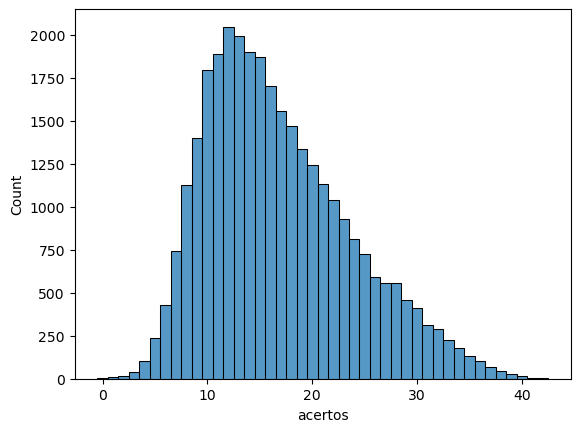

In [ ]:
sns.histplot(df,x='acertos',discrete=True)

## INEP Item coefficients 

In [33]:
itens = pd.read_csv('data/ITENS_PROVA_2019-utf8.csv')

In [34]:
itens[:2]

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
0,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Azul,551,1.0,0
1,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Laranja,565,1.0,0


In [35]:
df["11601"]

0        0
1        1
2        0
3        0
4        0
        ..
31497    0
31498    0
31499    1
31500    0
31501    1
Name: 11601, Length: 31502, dtype: int64

In [36]:
cols = df.columns[:43].astype('int')
params = itens[itens["CO_ITEM"].isin(cols)].drop_duplicates("CO_ITEM")
params = params[["CO_ITEM","NU_PARAM_A","NU_PARAM_B","NU_PARAM_C"]]
params = params.set_index("CO_ITEM")
params = params.sort_index(axis=0)
params.columns = ["a1","d","g"]
params['u'] = 1


In [37]:
comp_coef = pd.merge(coef3pl,params,left_index=True,right_index=True)
comp_coef

,a,b,c,u_x,a_se,b_se,c_se,u_se,a1,d,g,u_y
86751,3.349176,2.064273,0.103179,1.0,0.164493,0.026551,0.002006,NaN,3.45284,1.65017,0.09484,1
83820,1.668791,0.124362,0.231826,1.0,0.059228,0.035923,0.014627,NaN,2.24266,0.19945,0.14787,1
77940,0.704043,-0.354621,0.178133,1.0,0.056232,0.265673,0.070245,NaN,1.69265,-0.16281,0.19993,1
118034,2.190002,1.302246,0.164548,1.0,0.077340,0.017159,0.004209,NaN,2.89911,0.93429,0.16213,1
84811,1.696237,0.395927,0.168915,1.0,0.054027,0.025439,0.010495,NaN,2.78428,0.48121,0.18255,1
96447,2.284789,0.499533,0.131928,1.0,0.064450,0.015789,0.006611,NaN,3.56414,0.51626,0.13663,1
96302,0.820596,0.055822,0.005306,1.0,0.016923,0.023234,0.006042,NaN,1.13705,0.24894,0.00655,1
111820,1.476943,2.743631,0.097621,1.0,0.099315,0.082337,0.003126,NaN,1.43499,2.25728,0.06711,1
118033,2.122084,0.788235,0.334085,1.0,0.089340,0.022235,0.007422,NaN,3.33353,0.65950,0.32563,1
84769,1.572149,1.365492,0.143805,1.0,0.064507,0.021743,0.006206,NaN,2.20133,1.01836,0.12996,1


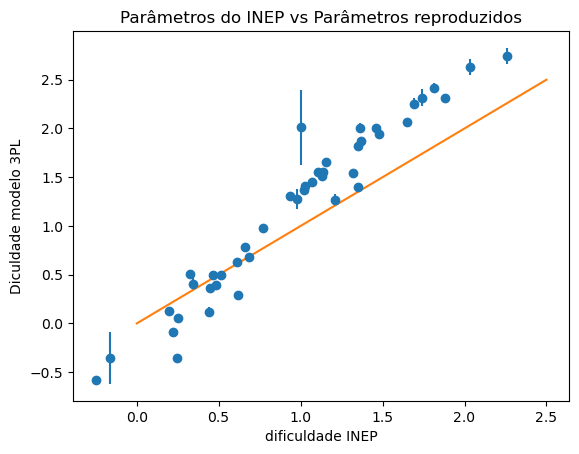

In [68]:
plt.errorbar(comp_coef['d'],comp_coef['b'],yerr=comp_coef['b_se'],fmt='o')
plt.plot([0,2.5],[0,2.5])
ax = plt.gca()
ax.set_title("Parâmetros do INEP vs Parâmetros reproduzidos")
ax.set_ylabel("Diculdade modelo 3PL");
ax.set_xlabel("dificuldade INEP");

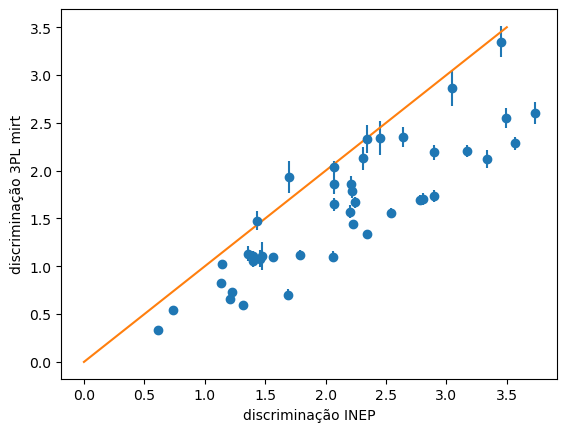

In [69]:
plt.errorbar(comp_coef['a1'],comp_coef['a'],yerr=comp_coef['a_se'],fmt='o')
plt.plot([0,3.5],[0,3.5])
ax = plt.gca()
ax.set_ylabel("discriminação 3PL mirt");
ax.set_xlabel("discriminação INEP");

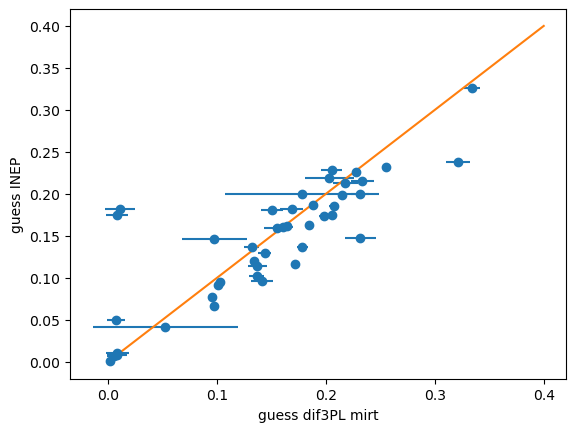

In [40]:
plt.errorbar(comp_coef['c'],comp_coef['g'],xerr=comp_coef['c_se'],fmt='o')
plt.plot([0,0.4],[0,0.4])
ax = plt.gca()
ax.set_xlabel("guess dif3PL mirt");
ax.set_ylabel("guess INEP");

In [41]:
params_m = mirt.traditional2mirt(to_rdf(params),"3PL")
mod_inep = mirtcat.generate_mirt_object(params_m,itemtype = '3PL')

In [42]:
thetas = to_rdf(pd.Series(np.arange(-4,4,0.01)))
thetas

<rpy2.rinterface.FloatSexpVector object at 0x7f4934162a00> [RTYPES.REALSXP]

In [43]:
to_df(mirt.testinfo(model3pl,thetas))

array([ 0.13795817,  0.13916691,  0.14038617,  0.14161601,  0.14285654,
        0.14410783,  0.14536998,  0.14664308,  0.14792722,  0.14922248,
        0.15052898,  0.15184678,  0.153176  ,  0.15451672,  0.15586903,
        0.15723304,  0.15860883,  0.15999651,  0.16139618,  0.16280792,
        0.16423184,  0.16566805,  0.16711662,  0.16857768,  0.17005132,
        0.17153764,  0.17303674,  0.17454873,  0.17607372,  0.1776118 ,
        0.17916308,  0.18072767,  0.18230568,  0.1838972 ,  0.18550236,
        0.18712126,  0.18875401,  0.19040072,  0.19206149,  0.19373645,
        0.19542571,  0.19712937,  0.19884755,  0.20058037,  0.20232794,
        0.20409038,  0.20586781,  0.20766033,  0.20946808,  0.21129117,
        0.21312971,  0.21498384,  0.21685367,  0.21873932,  0.22064092,
        0.22255859,  0.22449246,  0.22644264,  0.22840927,  0.23039247,
        0.23239238,  0.23440911,  0.2364428 ,  0.23849358,  0.24056158,
        0.24264693,  0.24474976,  0.24687021,  0.24900841,  0.25

<AxesSubplot:>

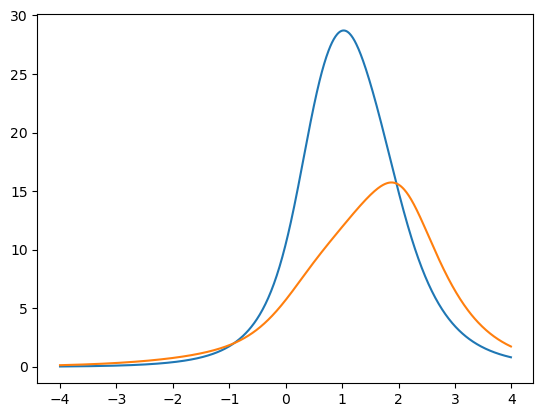

In [44]:
sns.lineplot(x=thetas,y=to_df(mirt.testinfo(mod_inep,thetas)))
sns.lineplot(x=thetas,y=to_df(mirt.testinfo(model3pl,thetas)))

In [45]:
1/np.sqrt(30)*slope

NameError: name 'slope' is not defined

In [214]:
mirt.logLik(model3pl)

-791320.8296484486


In [53]:
resp = df.iloc[:,range(43)]
resp.columns = resp.columns.astype("int")

In [54]:
resp = resp.sort_index(axis=1)
resp

,11601,33960,66219,66498,77940,78903,81689,83820,84147,84769,...,118022,118024,118029,118033,118034,118038,118054,118108,118125,118158
0,0,0,0,1,1,0,0,1,1,0,...,0,0,0,1,0,0,1,1,1,0
1,1,0,0,0,0,1,1,1,0,1,...,0,0,0,1,0,1,0,0,0,1
2,0,1,0,1,1,1,0,1,1,1,...,1,0,0,0,0,1,0,1,1,1
3,0,1,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,1
4,0,0,1,1,0,1,0,1,1,0,...,0,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,0,0,0,0,1,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,1
31498,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,1,1,1,1,0
31499,1,0,0,0,1,0,1,1,1,1,...,1,0,0,1,0,0,0,0,0,1
31500,0,0,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,1,0


In [55]:
%time inepthetas_eap= mirt.fscores(mod_inep,method="EAP",full_scores=True, full_scores_SE = True,returnER=True,verbose=True ,response_pattern = to_rdf(resp))


CPU times: user 19 s, sys: 0 ns, total: 19 s
Wall time: 19 s


In [57]:
df['inepthetas_eap'] = to_df(inepthetas_eap)[:,0]
df['inepthetasse_eap'] = to_df(inepthetas_eap)[:,1]

In [70]:
df.sort_values('inepthetas_eap',ascending=False)

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,118108,66219,111877,acertos,caderno,nota_inep,theta3pleap,theta3pleapse,inepthetas_eap,inepthetasse_eap
26612,1,1,1,1,1,1,1,1,1,1,...,1,1,1,42,507,787.4,3.059648,0.383892,2.546144,0.357871
11264,1,1,1,1,1,1,1,1,1,1,...,1,1,1,42,510,770.9,2.889337,0.351506,2.398971,0.326471
11025,1,1,1,1,1,1,1,1,1,1,...,1,1,1,41,510,765.7,2.787690,0.327265,2.352718,0.313076
10367,1,1,1,1,1,1,1,1,1,1,...,1,1,1,40,510,761.9,2.819340,0.335558,2.318918,0.308350
8803,1,1,1,1,1,1,1,1,1,1,...,1,1,1,40,510,760.0,2.791592,0.332149,2.301580,0.306113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,510,316.5,-1.952199,0.621786,-1.648256,0.588302
31269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,507,315.9,-1.953162,0.621389,-1.653506,0.586747
2023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,508,315.9,-1.953162,0.621389,-1.653506,0.586747
21980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,509,315.9,-1.953162,0.621389,-1.653506,0.586747


In [71]:
0.38*slope

42.67460971504481

In [58]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

112.3016045132758 501.49257989752016


0.7085784040769558

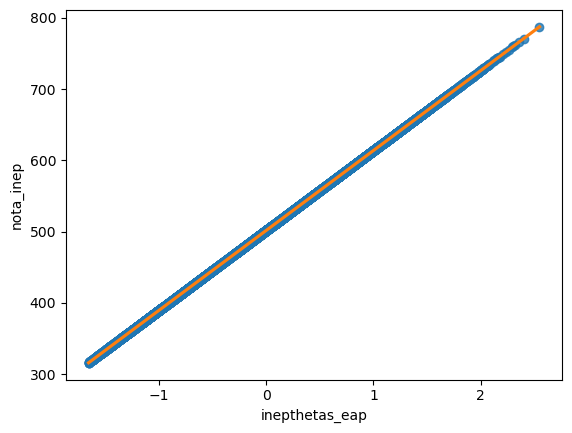

In [59]:
x = 'inepthetas_eap'
xs = 'inepthetasse_eap'

y = 'nota_inep'
df[x].dropna(inplace=True)
sns.regplot(df,x=x,y=y,ci=None,line_kws={"color": "C1"})
slope, intercept, r_value, p_value, std_err = stats.linregress(df[x],df[y])
print(slope,intercept)
df[x].std()

In [60]:
.71*112

79.52

<AxesSubplot:xlabel='acertos', ylabel='Count'>

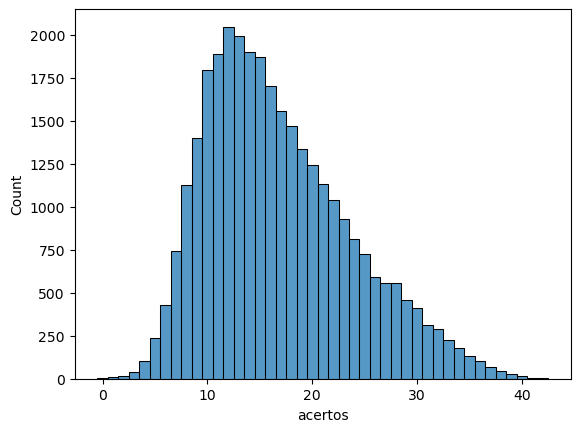

In [170]:
sns.histplot(df['acertos'],discrete=True)

<AxesSubplot:xlabel='inepthetas_eap', ylabel='inepthetasse_eap'>

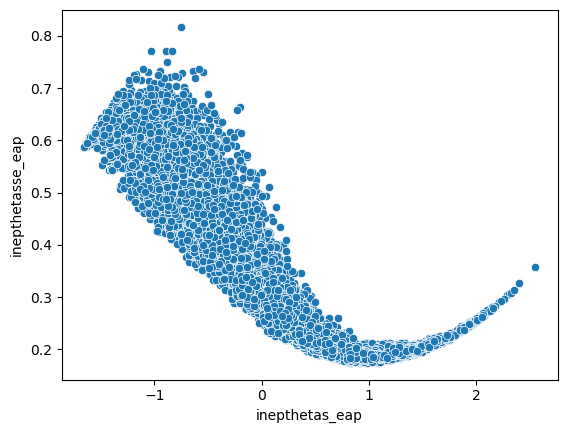

In [61]:
sns.scatterplot(df,x='inepthetas_eap',y='inepthetasse_eap')

Text(0.5, 1.0, 'Reprodução das notas do ENEM 2019\na partir do microdados')

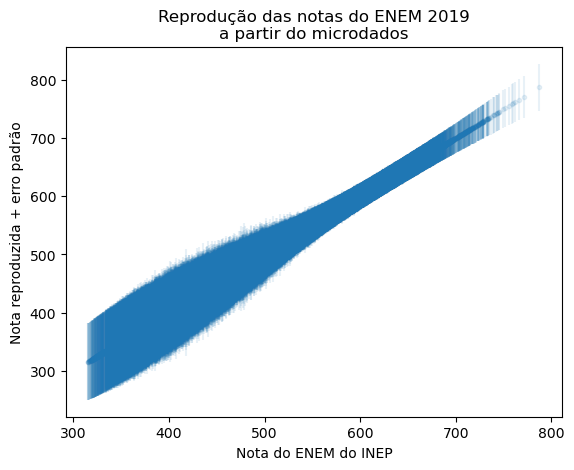

In [64]:
plt.errorbar(df['nota_inep'],df[x]*slope+intercept,yerr=df[xs]*slope,fmt=".",alpha=0.1)
ax = plt.gca()
ax.set_xlabel("Nota do ENEM do INEP")
ax.set_ylabel("Nota reproduzida + erro padrão")
ax.set_title("Reprodução das notas do ENEM 2019\na partir do microdados");


<AxesSubplot:xlabel='inepthetas_eap'>

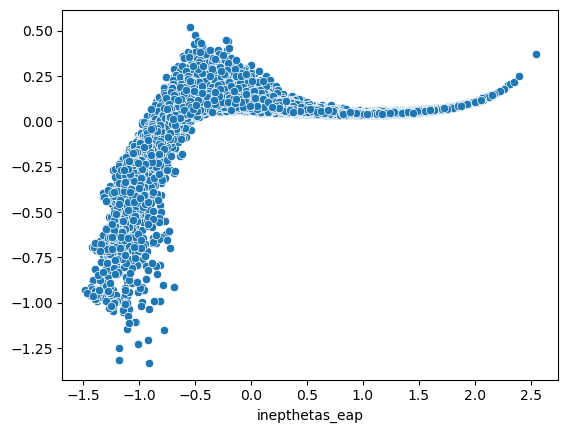

In [188]:
sns.scatterplot(x=df['inepthetas_eap'],y=(df['inepthetas_ml']-df['inepthetas_eap']))

In [ ]:
resp0 = resp.iloc[0:10]
resp0

,11601,33960,66219,66498,77940,78903,81689,83820,84147,84769,...,118022,118024,118029,118033,118034,118038,118054,118108,118125,118158
0,0,0,0,1,1,0,0,1,1,0,...,0,0,0,1,0,0,1,1,1,0
1,1,0,0,0,0,1,1,1,0,1,...,0,0,0,1,0,1,0,0,0,1
2,0,1,0,1,1,1,0,1,1,1,...,1,0,0,0,0,1,0,1,1,1
3,0,1,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,1
4,0,0,1,1,0,1,0,1,1,0,...,0,0,1,0,0,1,1,1,1,1
5,1,0,1,1,1,1,0,1,1,1,...,1,1,0,1,0,0,0,0,0,0
6,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,0,1,1,1,1,0,1,1,1,...,1,0,0,1,0,1,0,1,1,1
9,1,0,0,1,1,1,1,1,1,0,...,1,0,1,1,1,0,0,1,0,0


In [2]:
%%R -i mod_inep,resp0,resp,model3pl
respvec <- rep(0,43)
fscores(model3pl,method="EAP",full.scores=TRUE,full.scores_SE = TRUE,verbose=TRUE,plausible_draws = 5,response.pattern = resp0,plausible.draws=0)

UsageError: Cell magic `%%R` not found.


In [ ]:
mirt.fscores(mod_inep,method="EAP",full_scores=True, full_scores_SE = True,verbose=True ,response_pattern = to_rdf(resp0))


0.37521107383535723,-0.07957575825993186,0.766347840271049,0.6246480965530896,-0.0766048433492966,0.4433540524233607,-1.1266826187495147,-0.758486352622784,...,0.1827226900576905,0.19606398053893187
